In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
%matplotlib inline

In [3]:
eeg = pd.read_csv('EEG_merged.csv')
eeg.head()

,subject ID,Video ID,Attention,Meditation,Raw,Delta,Theta,Alpha 1,Alpha 2,Beta 1,Beta 2,Gamma1,Gamma2,predefined label,Self-defined label,age,ethnicity,gender
0,0,0,56,43,278,301963,90612,33735,23991,27946,45097,33228,8293,0,0,25,Han Chinese,M
1,0,0,40,35,-50,73787,28083,1439,2240,2746,3687,5293,2740,0,0,25,Han Chinese,M
2,0,0,47,48,101,758353,383745,201999,62107,36293,130536,57243,25354,0,0,25,Han Chinese,M
3,0,0,47,57,-5,2012240,129350,61236,17084,11488,62462,49960,33932,0,0,25,Han Chinese,M
4,0,0,44,53,-8,1005145,354328,37102,88881,45307,99603,44790,29749,0,0,25,Han Chinese,M


Put column names in consistent format:

In [4]:
renamed = []
# build new list of column names
for col in list(eeg.columns):
    newval = col.lower().replace(' ', '')
    renamed.append(newval)  

eeg.columns = renamed
eeg.head()

,subjectid,videoid,attention,meditation,raw,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2,predefinedlabel,self-definedlabel,age,ethnicity,gender
0,0,0,56,43,278,301963,90612,33735,23991,27946,45097,33228,8293,0,0,25,Han Chinese,M
1,0,0,40,35,-50,73787,28083,1439,2240,2746,3687,5293,2740,0,0,25,Han Chinese,M
2,0,0,47,48,101,758353,383745,201999,62107,36293,130536,57243,25354,0,0,25,Han Chinese,M
3,0,0,47,57,-5,2012240,129350,61236,17084,11488,62462,49960,33932,0,0,25,Han Chinese,M
4,0,0,44,53,-8,1005145,354328,37102,88881,45307,99603,44790,29749,0,0,25,Han Chinese,M


In [5]:
# id columns:
idcols = ['subjectid', 'videoid']

# numeric columns:
numcols = ['attention', 'meditation', 'raw', 'delta', 'theta', 'alpha1', 
           'alpha2', 'beta1', 'beta2', 'gamma1', 'gamma2', 'age']
# categorical columns:
catcols = ['ethnicity', 'gender']
# target predictor columns:
targetcols = ['predefinedlabel', 'self-definedlabel']

# set dummies on categorical columns:
catdummies = pd.get_dummies(eeg[catcols])

# convert eeg data to standard spreadsheet format:
stddata = pd.concat([eeg[idcols], eeg[numcols], catdummies, eeg[targetcols]], axis = 1)

# save dataset:
#stddata.to_csv('eeg_standardspreadsheet.csv')

## Look at distributions of numeric colums:

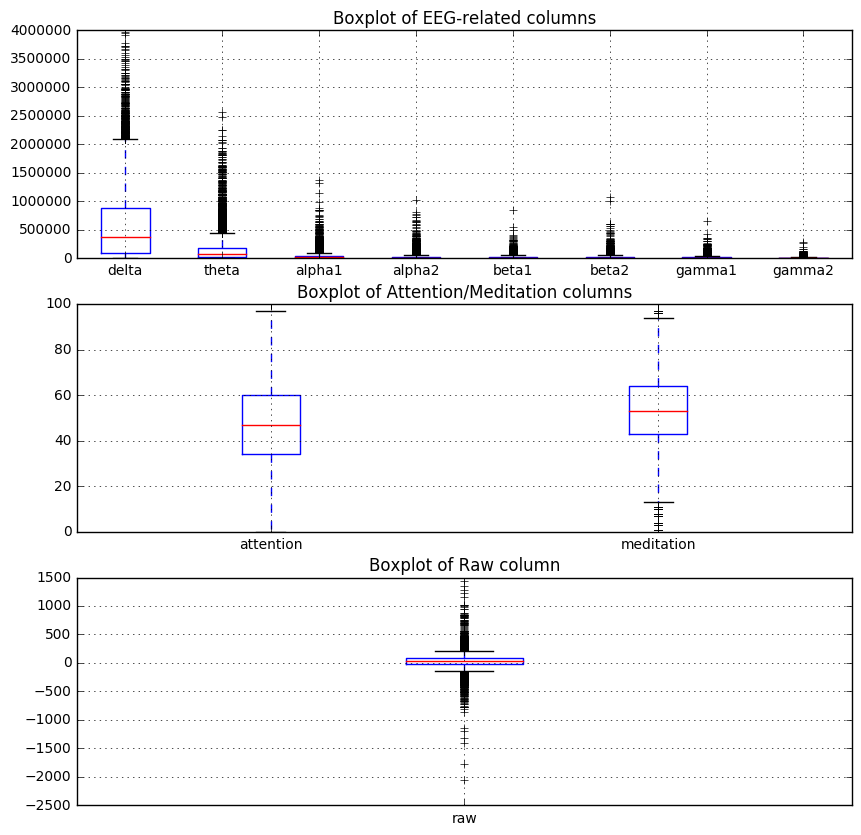

In [6]:
# all numeric columns other than attention, meditation, age:
eegcols = [col for col in numcols if col not in ['attention', 'meditation', 'raw', 'age']]
amcols = ['attention', 'meditation']
raw = ['raw']

fig = plt.figure(figsize = (10, 10))

plt.subplot(311)
stddata[eegcols].boxplot(return_type = 'axes')
plt.title('Boxplot of EEG-related columns')

plt.subplot(312)
stddata[amcols].boxplot(return_type = 'axes')
plt.title('Boxplot of Attention/Meditation columns')

plt.subplot(313)
stddata[raw].boxplot(return_type = 'axes')
plt.title('Boxplot of Raw column')

Definite problems with skew and different scales to the predictors.

## Transform Numeric columns to normalize & rescale:

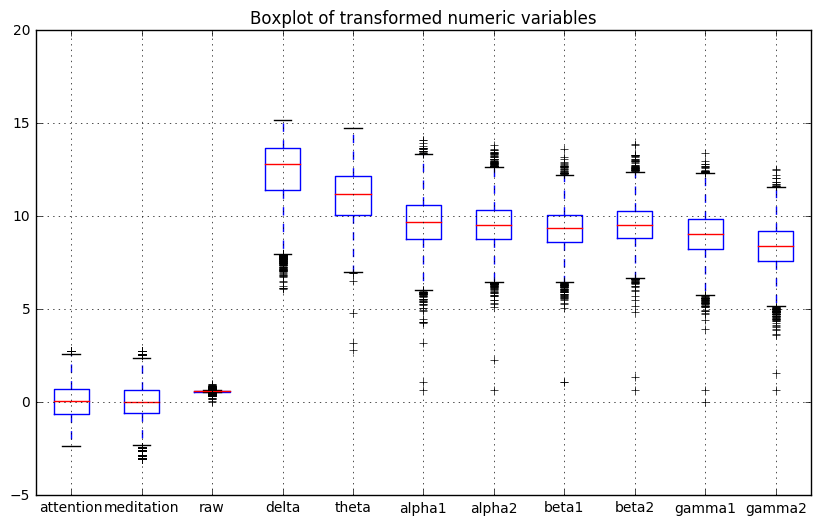

In [7]:
# log transform skewed columns:
eeg_logtransform = stddata[eegcols].apply(np.log, axis = 1)

# z scores for relatively normal columns:
attention_z = pd.DataFrame(stats.zscore(stddata[['attention']]))
meditation_z = pd.DataFrame(stats.zscore(stddata[['meditation']]))

att_med_zscores = pd.concat([attention_z, meditation_z], axis = 1)
att_med_zscores.columns = ['attention', 'meditation']

# min max transform for raw column:
raw_mm = (stddata[['raw']] - stddata[['raw']].min()) / (stddata[['raw']].max() - stddata[['raw']].min())

# concatenate transformed columns:
transformeddata = pd.concat([att_med_zscores, raw_mm, eeg_logtransform], axis = 1)

fig = plt.figure(figsize = (10, 6))
# display the results:
transformeddata.boxplot(return_type = 'axes')
plt.title('Boxplot of transformed numeric variables')

Still have some issues with the variables being on different scaless and with outliers.

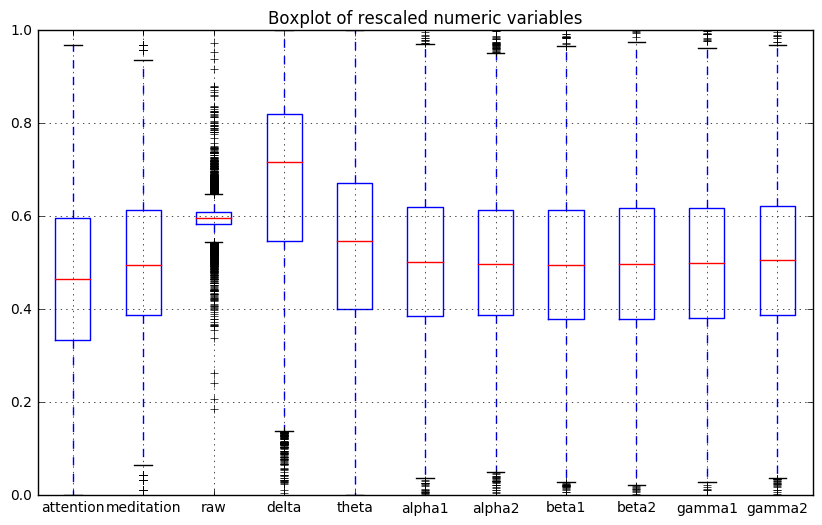

In [9]:
outlierrmcols = eegcols + amcols

# remove observations outside 3 standard deviations from the mean in the eeg columns:
for col in outlierrmcols:
    transformeddata = transformeddata[np.abs(transformeddata[col] - 
                                             transformeddata[col].mean()) <= (3.0 * transformeddata[col].std())]
# scale to a 0-1 interval:
for col in outlierrmcols:
    transformeddata[col] = (transformeddata[col] - transformeddata[col].min()) / \
    (transformeddata[col].max() - transformeddata[col].min())

# display results:  
fig = plt.figure(figsize = (10, 6))
transformeddata.boxplot(return_type = 'axes')
plt.title('Boxplot of rescaled numeric variables')

Now stratify the samples by subject ID after removing outliers

In [10]:
# remove records from the main dataset that contain outliers:
transformeddata_2 = stddata.ix[transformeddata.index.values, :]

# reset values in the 'transformeddata_2' set based on the transformed numerics:
transformeddata_2[transformeddata.columns] = transformeddata

# find the subjectid with the fewest number of observations to set sampling size:
counts = pd.DataFrame(transformeddata_2.groupby('subjectid').size().reset_index())
lowest = counts.loc[counts[0] == counts[0].min(), 'subjectid'].item()

# define list of subjects to sample (excluding lowest guy):
subs = list(transformeddata_2['subjectid'].unique())
subs.remove(lowest)

In [16]:
# initialize final dataframe with the data from the smallest guy:
finaldata = transformeddata_2.ix[transformeddata_2.subjectid == lowest, :].copy()
minrows = finaldata.shape[0]

np.random.seed(seed=1234)

# go through the rest of the subjects, sample, and concatenate with final dataframe:
for sub in subs:
    subset = transformeddata_2.ix[transformeddata_2.subjectid == sub, :]
    subsetidx = random.sample(list(subset.index.values), minrows)
    newdata = subset.ix[subsetidx, :]
    finaldata = pd.concat([finaldata, newdata], axis = 0)


#finaldata.to_csv('EEG_norm_outliers_removed_strat.csv')

10305

In [13]:
finaldata[numcols].corr()

,attention,meditation,raw,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2,age
attention,1.000000,0.164493,-0.008081,-0.336366,-0.376177,-0.256153,-0.211569,-0.122266,0.039455,-0.066915,0.024126,0.152327
meditation,0.164493,1.000000,0.020244,-0.181082,-0.251184,0.063876,0.064692,-0.068936,-0.138592,-0.120564,-0.088287,0.114275
raw,-0.008081,0.020244,1.000000,-0.013510,-0.019568,-0.019098,-0.005930,-0.013144,-0.021964,-0.020244,-0.011503,-0.003512
delta,-0.336366,-0.181082,-0.013510,1.000000,0.725250,0.552355,0.482536,0.413837,0.419538,0.424684,0.246172,-0.443671
theta,-0.376177,-0.251184,-0.019568,0.725250,1.000000,0.670655,0.619187,0.613329,0.569253,0.542885,0.430965,-0.321774
alpha1,-0.256153,0.063876,-0.019098,0.552355,0.670655,1.000000,0.611813,0.596734,0.557578,0.514540,0.420624,-0.215953
alpha2,-0.211569,0.064692,-0.005930,0.482536,0.619187,0.611813,1.000000,0.631603,0.616550,0.558396,0.447076,-0.201289
beta1,-0.122266,-0.068936,-0.013144,0.413837,0.613329,0.596734,0.631603,1.000000,0.633278,0.591398,0.599316,-0.147409
beta2,0.039455,-0.138592,-0.021964,0.419538,0.569253,0.557578,0.616550,0.633278,1.000000,0.775412,0.661629,-0.207178
gamma1,-0.066915,-0.120564,-0.020244,0.424684,0.542885,0.514540,0.558396,0.591398,0.775412,1.000000,0.729811,-0.225013


Now make the final dataframe for analysis

## New section - group data at subjectid + videoid level before analysis:

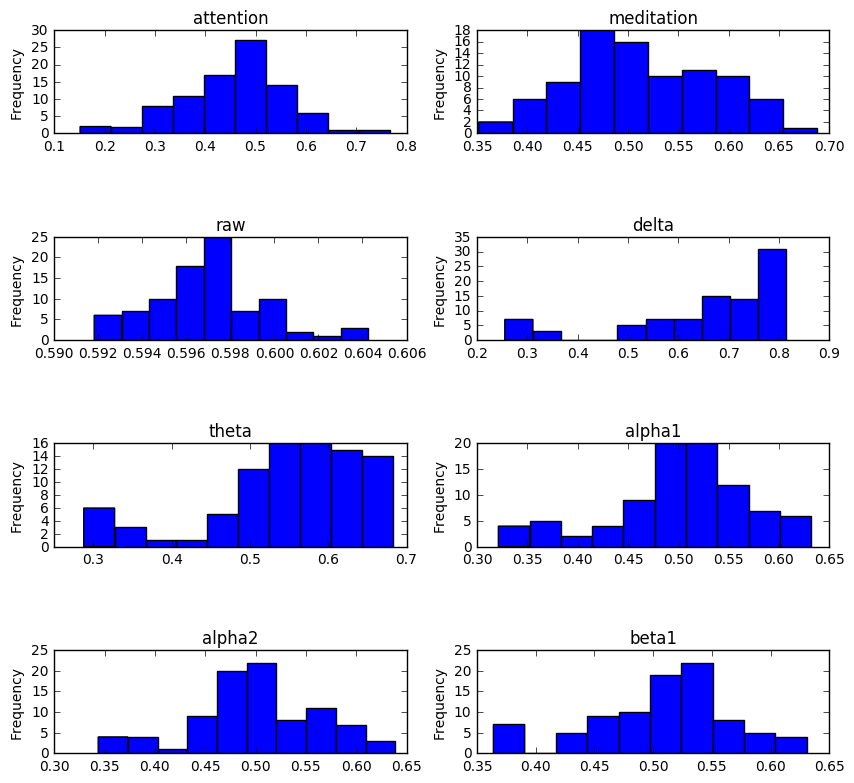

In [150]:
subvid = finaldata.groupby(['subjectid', 'videoid']).mean()

fig = plt.figure(figsize = (10, 20))
fig.subplots_adjust(hspace=1.0)

plt.subplot(821)
subvid['attention'].plot(kind = 'hist')
plt.title('attention')

plt.subplot(822)
subvid['meditation'].plot(kind = 'hist')
plt.title('meditation')

plt.subplot(823)
subvid['raw'].plot(kind = 'hist')
plt.title('raw')

plt.subplot(824)
subvid['delta'].plot(kind = 'hist')
plt.title('delta')

plt.subplot(825)
subvid['theta'].plot(kind = 'hist')
plt.title('theta')

plt.subplot(826)
subvid['alpha1'].plot(kind = 'hist')
plt.title('alpha1')

plt.subplot(827)
subvid['alpha2'].plot(kind = 'hist')
plt.title('alpha2')

plt.subplot(828)
subvid['beta1'].plot(kind = 'hist')
plt.title('beta1')


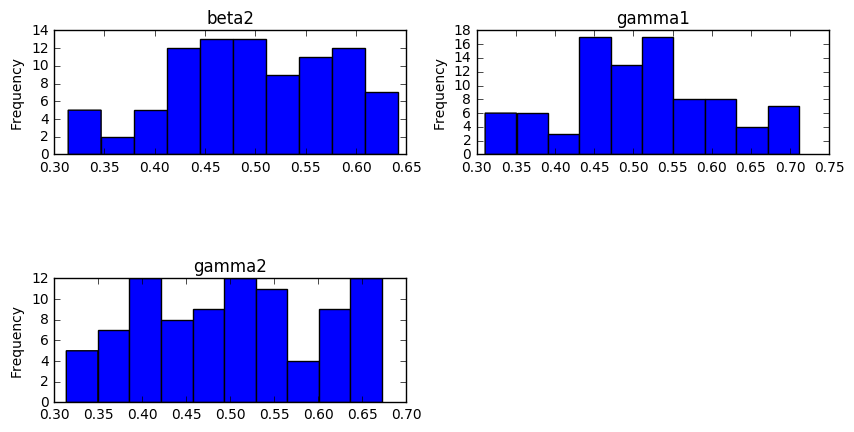

In [151]:
fig = plt.figure(figsize = (10, 8))
fig.subplots_adjust(hspace=1.0)

plt.subplot(321)
subvid['beta2'].plot(kind = 'hist')
plt.title('beta2')

plt.subplot(322)
subvid['gamma1'].plot(kind = 'hist')
plt.title('gamma1')

plt.subplot(323)
subvid['gamma2'].plot(kind = 'hist')
plt.title('gamma2')